# GBM(Gradient Boosting Machine)

부스팅 알고리즘은 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여 -> 오류 개선 -> 학습

#### 부스팅의 대표적인 알고리즘 
* AdaBoost(Adaptive boosting)
* GBM(Gradient Boost Machine)
* XGBoost
* LightGBM
* CatBoost


### AdaBoost(Adaptive boosting)

오류 데이터에 가중치 부여하면서 부스팅 수행. 속도나 성능적인 측면에서 decision Tree를 약한 학습기로 사용.

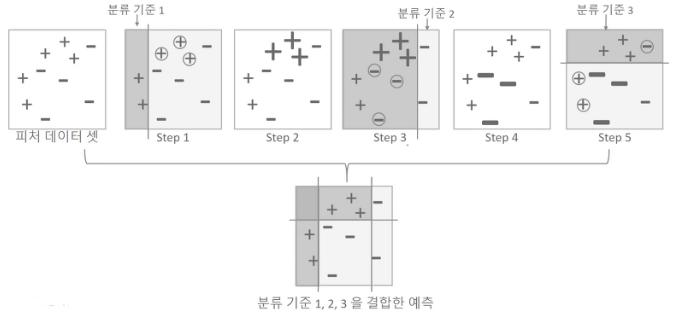

**Step 1)** 첫 번째 약한 학습기가 분류 기준 1로 +와 -를 분류. ⊕ 데이터는 + 데이터가 잘못 분류된 오류 데이터.

**Step 2)** 잘못 분류된 데이터에 가중치 부여 -> 크기 커짐

**Step 3)** 두 번째 약한 학습기가 분류 기준 2로 +와 -를 분류. ⊖ 데이터는 - 데이터가 잘못 분류된 오류 데이터

**Step 4)** 잘못 분류된 데이터에 가중치 부여 -> 크기 커짐

**Step 5)** 세 번재 약한 학습기가 분류 기준 3으로 +와 -를 분류해서 오류 데이터 찾음

**Step 6)** 마지막으로 약한 학습기들 모두 결합한 결과 예측 수행

=> 개별 약한 학습기보다 훨씬 정확도가 높은 예측 결과를 만듦.

#### AdaBoost의 하이퍼 파라미터

* base_estimators : 학습에 사용하는 알고리즘. Default=None -> DecisionTreeClassifier(max_depth=1) 적용

* n_estimators : 생성할 약한 학습기 개수 지정. Default=50

* learning_rate : 학습을 진행할 때마다 적용하는 학습률(0~1). weak learner가 순차적으로 오류값을 보정해나갈 때 적용하는 계수. Default=1.0

n_estimators를 늘리면 생성하는 weak learner 수 늘어나는데, 이 여러 학습기들의 dicision boundary 가 많아지면서 모델 복잡해진다.

learning_rate를 줄이면 가중치 갱신의 변동폭이 감소해서, 여러 학습기들의 decision boundary 차이가 줄어듦

위 두가지는 trade-off 관계다. n_estimators를 늘리거나 learning_rate를 줄인다면 서로 효과가 상쇄된다. => 이 두 파라미터를 잘 조정하는 것이 알고리즘의 핵심이다.

In [1]:
from sklearn.metrics import accuracy_score
import time
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1]) if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [3]:
def get_human_dataset():
    # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('./features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv('./X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./X_test.txt', sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action을 ㅗ부여
    y_train = pd.read_csv('./y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./y_test.txt', sep='\s+', header=None, names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [4]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# AdaBoost 수행 시간 측정을 위한 시작 시간 설정
start_time = time.time()

dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(random_state=0, base_estimator=dt_clf, learning_rate=0.1)
ada_clf.fit(X_train, y_train)
ada_pred = ada_clf.predict(X_test)
ada_accuracy = accuracy_score(y_test, ada_pred)

print('AdaBoost 정확도 : {0:.4f}'.format(ada_accuracy))
print('AdaBoost 수행시간 : {0:.1f} 초'.format(time.time() - start_time))

AdaBoost 정확도 : 0.8561
AdaBoost 수행시간 : 5.4 초


### GBM

AdaBoost와 유사하지만, 가중치 업데이트를 경사 하강법(Gradient Descent)을 이용하여 최적화된 결과를 얻는 알고리즘이다.

GBM은 예측 성능이 높지만, Greedy Algorithm으로 과적합이 빠르게 되고, 시간이 오래 걸린다는 단점이 있다. 반면 랜덤 포레스트의 경우 빠른 수행 시간을 보장해주기 때문에 더 쉽게 예측 결과를 도출할 수 있다.

※ 경사 하강법

분류의 실제값을 y, 피처(x1, x2 ...)에 기반한 예측함수를 F(x), 오류식(실제값 - 예측값)을 h(x) = y - F(x)이라 하면 이 오류식을 최소화하는 방향성을 가지고 반복적으로 가중치 값을 업데이트.

In [5]:
# GBM
from sklearn.ensemble import GradientBoostingClassifier

# GBM 수행 시간 측정을 위한 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))
print('GBM 수행시간 : {0:.1f} 초'.format(time.time() - start_time))

GBM 정확도 : 0.9386
GBM 수행시간 : 815.6 초


### GBM 하이퍼 파라미터 및 튜닝

* loss : 경사 하강법에서 사용할 비용 함수 지정. 특별한 이유가 없으면 Default값인 deviance 적용

* n_estimators : 생성할 weak learner의 개수 지정. Default=100.

* learning_rate : 학습을 진행할 때마다 적용하는 학습률(0~1). Weak learner가 순차적으로 오류값을 보정해 나가는데 적용하는 계수. Default=0.1 낮은 만큼 최소 오류 값을 찾아 예측 성능이 높아질 수 있다. 하지만 많은 수의 트리가 필요하고 시간이 많이 요소

* subsample : 개별 weak learner가 학습에 사용하는 데이터 샘플링 비율(0~1) Default=1(전체 데이터 학습). 이 값을 조절하여 트리 간의 상관도를 줄일 수 있다.

In [6]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1] 
}

grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1, n_jobs=-1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터 :\n', grid_cv.best_params_)
print('최고 예측 정확도 : {0:.4f}'.format(grid_cv.best_score_))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터 :
 {'learning_rate': 0.05, 'n_estimators': 500}
최고 예측 정확도 : 0.9002


In [7]:
# GridSearchCV를 이용해 최적으로 학습된 estimator로 예측 수행
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))

GBM 정확도 : 0.9393
